# İMPORTİNG PART

In [1]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.7 MB/s eta 0:00:00


In [89]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# DATA EXPLORATİON AND VİSUALİZATİON

In [3]:
base_df = pd.read_csv("car_acceptability.txt", header=None)
base_df.columns = ["buying","maint","doors","persons","lug_boot","safety","class"]

In [4]:
def check_df(dataframe, head=5):
    print('##################### Shape #####################')
    print(dataframe.shape)
    print('##################### Types #####################')
    print(dataframe.dtypes)
    print('##################### Head #####################')
    print(dataframe.head(head))
    print('##################### Tail #####################')
    print(dataframe.tail(head))
    print('##################### NA #####################')
    print(dataframe.isnull().sum())
    print('##################### Quantiles #####################')
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [5]:
check_df(dataframe = base_df, head = 5)

##################### Shape #####################
(1729, 7)
##################### Types #####################
buying      object
maint       object
doors       object
persons     object
lug_boot    object
safety      object
class       object
dtype: object
##################### Head #####################
  buying  maint doors persons lug_boot safety  class
0  vhigh  vhigh     2       2    small    low  unacc
1  vhigh  vhigh     2       2    small    med  unacc
2  vhigh  vhigh     2       ?    small   high  unacc
3  vhigh  vhigh     2       2      med    low  unacc
4  vhigh  vhigh     2       2      med      ?  unacc
##################### Tail #####################
     buying maint  doors persons lug_boot safety  class
1724    low   low  5more    more      med   high  vgood
1725    low   low  5more    more      big    low  unacc
1726    low   low  5more    more      big    med   good
1727    low   low  5more    more      big   high  vgood
1728      ?     ?      ?       ?        ?      

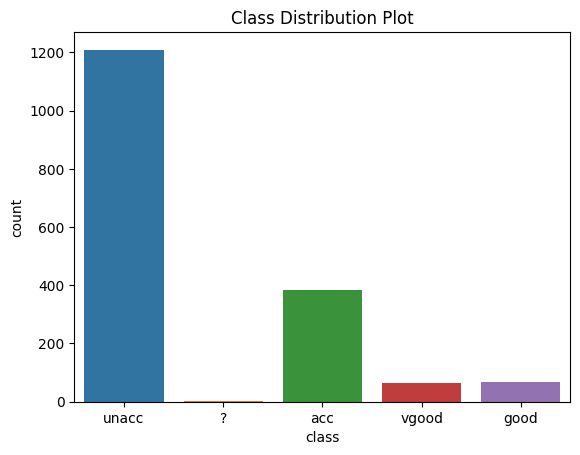

In [6]:
sns.countplot(x="class", data = base_df)
plt.title("Class Distribution Plot")
plt.show()

# Not well balanced target feature and has unknown value!

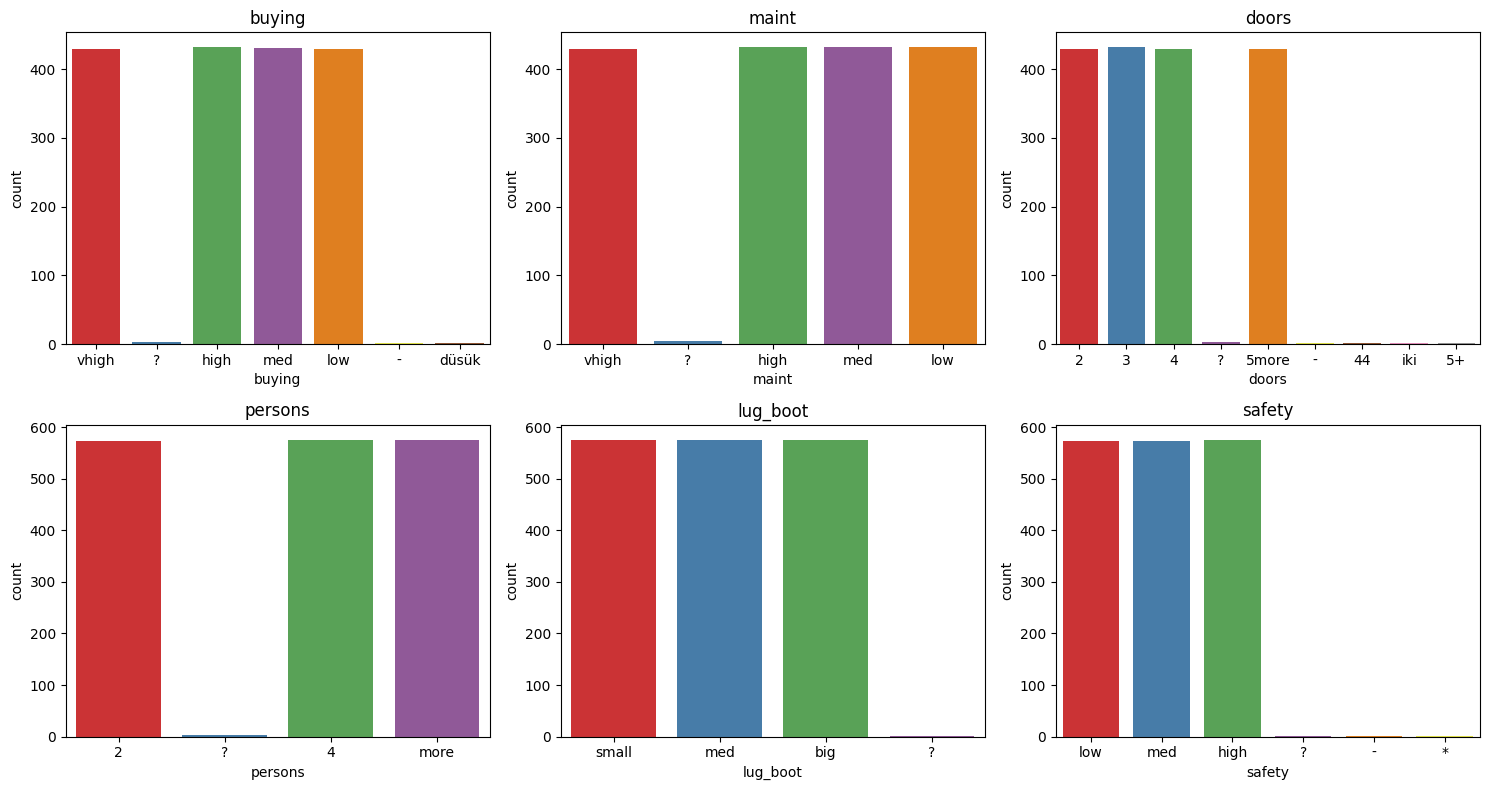

In [7]:
# Define categorical columns and titles for subplots
categorical_vars = base_df.drop("class", axis = 1).columns
titles = ['Kategori Sayısı', 'Değer Sayısı']

plt.figure(figsize=(15, 8))

for i in range(len(categorical_vars)):
    plt.subplot(2, 3, i+1)
    sns.countplot(data=base_df, x=categorical_vars[i], palette='Set1')
    plt.title(categorical_vars[i])
plt.tight_layout()
plt.show()

# Well balanced but has unknown values. Should be cleared before encode.

# DATA PREPROCESSİNG

In [8]:
unknown_value_mapping = {
    'düsük': "low",
    '44': "4", 'iki': "2", '5+': "5more",
    "?" : pd.NA, "*" : pd.NA, "-" : pd.NA
}

encode_mapping = {
    'low': 0, 'med': 1, 'high': 2, 'vhigh': 3,
    'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3,
    'small': 0, 'big': 2, 'more': 5, '5more': 5,
    '2': 2, '3': 3, '4': 4,
}

# Data Transforms
base_df.replace(unknown_value_mapping, inplace=True)
# Delete the missing values
base_df.dropna(axis = 0, inplace= True)
# Encode the data
encoded_df = base_df.replace(encode_mapping)
# Object to int - Manualy
encoded_df = encoded_df.astype(int)

In [9]:
# All columns are int64 and dont have any missing or nan value
base_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1714 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1714 non-null   object
 1   maint     1714 non-null   object
 2   doors     1714 non-null   object
 3   persons   1714 non-null   object
 4   lug_boot  1714 non-null   object
 5   safety    1714 non-null   object
 6   class     1714 non-null   object
dtypes: object(7)
memory usage: 107.1+ KB


<Axes: >

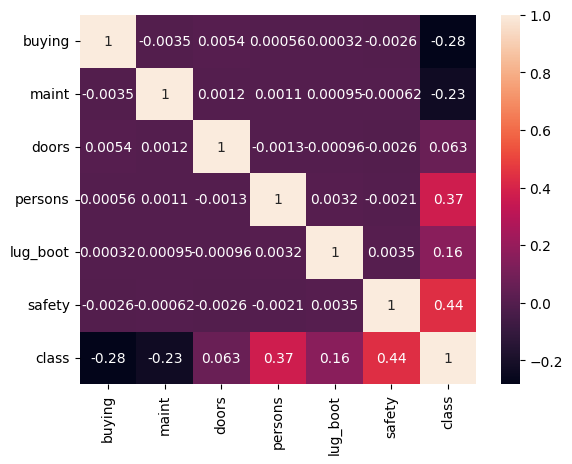

In [10]:
# All columns encoded. Now, we can get corr table.
sns.heatmap(data= encoded_df.corr(), annot= True)


# DATA TRAİN TEST SPLİT

In [11]:
X = encoded_df.drop("class", axis = 1)
y = encoded_df["class"]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 10,
                                                    stratify = y)

# METHOD TO GET MODEL'S SCORES

In [55]:
def get_scores(y_true, y_pred, model):
  return accuracy_score(y_true, y_pred), classification_report(y_true, y_pred), confusion_matrix(y_true, y_pred), cross_val_score(model, X, y, cv = 5 ).mean()

# MODELİNG PART

In [13]:
vanilla_knn = KNeighborsClassifier()
vanilla_knn.fit(X_train, y_train)
vanilla_knn_preds = vanilla_knn.predict(X_test)

In [69]:
vanilla_knn_scores = get_scores(y_test, vanilla_knn_preds, vanilla_knn)

In [14]:
vanilla_svc = SVC()
vanilla_svc.fit(X_train, y_train)
vanilla_svc_preds = vanilla_svc.predict(X_test)

In [70]:
vanilla_svc_scores = get_scores(y_test, vanilla_svc_preds, vanilla_svc)

In [15]:
vanilla_dt = DecisionTreeClassifier()
vanilla_dt.fit(X_train, y_train)
vanilla_dt_preds = vanilla_dt.predict(X_test)

In [71]:
vanilla_dt_scores = get_scores(y_test, vanilla_dt_preds, vanilla_dt)

In [16]:
vanilla_rf = RandomForestClassifier()
vanilla_rf.fit(X_train, y_train)
vanilla_rf_preds = vanilla_rf.predict(X_test)

In [72]:
vanilla_rf_scores = get_scores(y_test, vanilla_rf_preds, vanilla_rf)

In [17]:
vanilla_lr = LogisticRegression(max_iter=500)
vanilla_lr.fit(X_train, y_train)
vanilla_lr_preds = vanilla_lr.predict(X_test)

In [73]:
vanilla_lr_scores = get_scores(y_test, vanilla_lr_preds, vanilla_lr)

In [18]:
vanilla_gb = GradientBoostingClassifier()
vanilla_gb.fit(X_train, y_train)
vanilla_gb_preds = vanilla_gb.predict(X_test)

In [74]:
vanilla_gb_scores = get_scores(y_test, vanilla_gb_preds, vanilla_gb)

In [19]:
vanilla_xgb = XGBClassifier()
vanilla_xgb.fit(X_train, y_train)
vanilla_xgb_preds = vanilla_xgb.predict(X_test)

In [75]:
vanilla_xgb_scores = get_scores(y_test, vanilla_xgb_preds, vanilla_xgb)

In [20]:
vanilla_lgb = LGBMClassifier()
vanilla_lgb.fit(X_train, y_train)
vanilla_lgb_preds = vanilla_lgb.predict(X_test)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23
[LightGBM] [Info] Number of data points in the train set: 1371, number of used features: 6
[LightGBM] [Info] Start training from score -0.357405
[LightGBM] [Info] Start training from score -1.502984
[LightGBM] [Info] Start training from score -3.215962
[LightGBM] [Info] Start training from score -3.272052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [76]:
vanilla_lgb_scores = get_scores(y_test, vanilla_lgb_preds, vanilla_lgb)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23
[LightGBM] [Info] Number of data points in the train set: 1371, number of used features: 6
[LightGBM] [Info] Start training from score -0.357405
[LightGBM] [Info] Start training from score -1.502984
[LightGBM] [Info] Start training from score -3.215962
[LightGBM] [Info] Start training from score -3.272052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [21]:
categorical_features = list(base_df.drop("class", axis = 1).columns)
train_pool = Pool(X_train, y_train, cat_features = categorical_features)
test_pool = Pool(X_test, y_test, cat_features = categorical_features)
vanilla_cb = CatBoostClassifier()
vanilla_cb.fit(train_pool)
vanilla_cb_preds = vanilla_cb.predict(test_pool)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
4:	learn: 0.9137080	total: 5.36ms	remaining: 1.07s
5:	learn: 0.8587160	total: 6.45ms	remaining: 1.07s
6:	learn: 0.8054299	total: 7.53ms	remaining: 1.07s
7:	learn: 0.7596857	total: 8.29ms	remaining: 1.03s
8:	learn: 0.7119690	total: 9.36ms	remaining: 1.03s
9:	learn: 0.6776548	total: 10.4ms	remaining: 1.03s
10:	learn: 0.6417950	total: 11.4ms	remaining: 1.03s
11:	learn: 0.6075769	total: 12.5ms	remaining: 1.03s
12:	learn: 0.5788214	total: 13.6ms	remaining: 1.03s
13:	learn: 0.5486506	total: 14.6ms	remaining: 1.02s
14:	learn: 0.5216546	total: 15.6ms	remaining: 1.02s
15:	learn: 0.4971971	total: 16.7ms	remaining: 1.03s
16:	learn: 0.4785955	total: 17.8ms	remaining: 1.03s
17:	learn: 0.4570639	total: 18.9ms	remaining: 1.03s
18:	learn: 0.4383475	total: 19.9ms	remaining: 1.03s
19:	learn: 0.4180866	total: 21.2ms	remaining: 1.04s
20:	learn: 0.3998092	total: 22.3ms	remaining: 1.04s
21:	learn: 0.3846594	total: 23.5ms	remaining: 1.04s
22:	learn: 0.3681856	to

In [77]:
vanilla_cb_scores = get_scores(y_test, vanilla_cb_preds, vanilla_cb)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
4:	learn: 0.9137080	total: 5.91ms	remaining: 1.18s
5:	learn: 0.8587160	total: 7.21ms	remaining: 1.2s
6:	learn: 0.8054299	total: 8.37ms	remaining: 1.19s
7:	learn: 0.7596857	total: 9.39ms	remaining: 1.16s
8:	learn: 0.7119690	total: 11.8ms	remaining: 1.3s
9:	learn: 0.6776548	total: 13.1ms	remaining: 1.3s
10:	learn: 0.6417950	total: 14.7ms	remaining: 1.32s
11:	learn: 0.6075769	total: 16.1ms	remaining: 1.32s
12:	learn: 0.5788214	total: 17.6ms	remaining: 1.34s
13:	learn: 0.5486506	total: 18.7ms	remaining: 1.32s
14:	learn: 0.5216546	total: 20ms	remaining: 1.31s
15:	learn: 0.4971971	total: 21.3ms	remaining: 1.31s
16:	learn: 0.4785955	total: 22.6ms	remaining: 1.3s
17:	learn: 0.4570639	total: 24ms	remaining: 1.31s
18:	learn: 0.4383475	total: 25.2ms	remaining: 1.3s
19:	learn: 0.4180866	total: 26.9ms	remaining: 1.32s
20:	learn: 0.3998092	total: 28ms	remaining: 1.31s
21:	learn: 0.3846594	total: 29.7ms	remaining: 1.32s
22:	learn: 0.3681856	total: 31.1ms

# Model Tuning Part

In [33]:
knn_param_dist = {"n_neighbors": [3,5,7,9],
                  "weights": ["uniform","distance"]}
knn_grid = GridSearchCV(estimator=vanilla_knn, param_grid=knn_param_dist, cv= 5)
knn_grid.fit(X_train, y_train)
best_knn = knn_grid.best_estimator_
best_knn_preds = best_knn.predict(X_test)

In [56]:
best_knn_scores = get_scores(y_test, best_knn_preds, best_knn)
best_knn_scores[3]

0.8051642712222733

In [27]:
svc_param_dist = {"C":[0.01,0.1,1,10],
                  "kernel":["rbf","sigmoid","linear","poly"]}
svc_grid = GridSearchCV(estimator = vanilla_svc, param_grid = svc_param_dist, cv = 5)
svc_grid.fit(X_train, y_train)
best_svc = svc_grid.best_estimator_
best_svc_preds = best_svc.predict(X_test)

In [57]:
best_svc_scores = get_scores(y_test, best_svc_preds, best_svc)
best_svc_scores[3]

0.8885819992157264

In [29]:
dt_param_dist = {"criterion": ["gini","entropy"],
                 "max_depth":[3,5,7,9],
                 "min_samples_split":[5,7,9],
                 "min_samples_leaf":[3,5]
                 }
dt_grid = GridSearchCV(estimator = vanilla_dt, param_grid = dt_param_dist, cv = 5)
dt_grid.fit(X_train, y_train)
best_dt = dt_grid.best_estimator_
best_dt_preds = best_dt.predict(X_test)


In [58]:
best_dt_scores = get_scores(y_test, best_dt_preds, best_dt)
best_dt_scores[3]

0.8214908018345183

In [37]:
rf_param_dist = {"n_estimators":[150,300,450],
                "criterion": ["gini","entropy"],
                 "max_depth":[3,5,7,9],
                 "max_samples":[0.6],
                 "min_samples_split":[5,7,9],
                 "min_samples_leaf":[3,5],
                 "bootstrap":[True],
                 "max_features":["auto","sqrt"]
                 }
rf_grid = GridSearchCV(estimator = vanilla_rf, param_grid = rf_param_dist, cv =5)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_
best_rf_preds = best_rf.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

In [60]:
best_rf_scores = get_scores(y_test, best_rf_preds, best_rf)
best_rf_scores[3]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

0.8267454350161116

In [40]:
lr_param_dist = {"penalty":["l1","l2"],
                 "C":[0.01, 0.1, 1],
                 "solver":["saga","lbfgs","newton-cg"],
                 "max_iter":[500,750,1000]}
lr_grid = GridSearchCV(estimator = vanilla_lr, param_grid = lr_param_dist, cv = 5)
lr_grid.fit(X_train, y_train)
best_lr = lr_grid.best_estimator_
best_lr_predicts = best_lr.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

In [61]:
best_lr_scores = get_scores(y_test, best_lr_predicts, best_lr)
best_lr_scores[3]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.7799413499735735

In [42]:
gb_param_dist = {"n_estimators":[100,200,300],
                 "learning_rate":[0.05, 0.1, 0.15],
                 "max_depth":[3,5,7],
                 "subsample":[0.6,0.8],
                 }
gb_grid = GridSearchCV(estimator = vanilla_gb, param_grid = gb_param_dist, cv = 5)
gb_grid.fit(X_train, y_train)
best_gb = gb_grid.best_estimator_
best_gb_predicts = best_gb.predict(X_test)

In [62]:
best_gb_scores = get_scores(y_test, best_gb_predicts, best_gb)
best_gb_scores[3]

0.835479856102842

In [44]:
xgb_param_dist = {"n_estimators":[100,200,300],
                 "learning_rate":[0.05, 0.1, 0.15],
                 "max_depth":[3,5,7],
                 "subsample":[0.6,0.8],
                 }
xgb_grid = GridSearchCV(estimator = vanilla_xgb, param_grid = xgb_param_dist, cv = 5)
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_
best_xgb_predicts = best_xgb.predict(X_test)

In [63]:
best_xgb_scores = get_scores(y_test, best_xgb_predicts, best_xgb)
best_xgb_scores[3]

0.8448365812490408

In [46]:
lgb_param_dist = {"n_estimators":[100,200,300],
                 "learning_rate":[0.05, 0.1, 0.15],
                 "max_depth":[3,5,7],
                 "subsample":[0.6,0.8],
                 }
lgb_grid = GridSearchCV(estimator = vanilla_lgb, param_grid = lgb_param_dist, cv = 5)
lgb_grid.fit(X_train, y_train)
best_lgb = lgb_grid.best_estimator_
best_lgb_predicts = best_lgb.predict(X_test)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In [64]:
best_lgb_scores = get_scores(y_test, best_lgb_predicts, best_lgb)
best_lgb_scores[3]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23
[LightGBM] [Info] Number of data points in the train set: 1371, number of used features: 6
[LightGBM] [Info] Start training from score -0.357405
[LightGBM] [Info] Start training from score -1.502984
[LightGBM] [Info] Start training from score -3.215962
[LightGBM] [Info] Start training from score -3.272052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

0.854757642405333

In [49]:
cb_param_dist = {"iterations":[100,200,300],
                 "learning_rate":[0.05, 0.1, 0.15],
                 "depth":[3,5,7,9]}
cb_grid = GridSearchCV(estimator = vanilla_cb, param_grid = cb_param_dist, cv = 5)
cb_grid.fit(X_train, y_train)
best_cb = cb_grid.best_estimator_
best_cb_predicts = best_cb.predict(X_test)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
100:	learn: 0.0490870	total: 183ms	remaining: 180ms
101:	learn: 0.0485805	total: 185ms	remaining: 178ms
102:	learn: 0.0480006	total: 187ms	remaining: 176ms
103:	learn: 0.0475058	total: 189ms	remaining: 174ms
104:	learn: 0.0469771	total: 190ms	remaining: 172ms
105:	learn: 0.0464585	total: 192ms	remaining: 170ms
106:	learn: 0.0459292	total: 194ms	remaining: 169ms
107:	learn: 0.0454872	total: 196ms	remaining: 167ms
108:	learn: 0.0450593	total: 198ms	remaining: 165ms
109:	learn: 0.0446220	total: 199ms	remaining: 163ms
110:	learn: 0.0439884	total: 201ms	remaining: 161ms
111:	learn: 0.0435236	total: 203ms	remaining: 159ms
112:	learn: 0.0430387	total: 204ms	remaining: 157ms
113:	learn: 0.0426134	total: 206ms	remaining: 156ms
114:	learn: 0.0422290	total: 208ms	remaining: 154ms
115:	learn: 0.0418464	total: 210ms	remaining: 152ms
116:	learn: 0.0414394	total: 212ms	remaining: 150ms
117:	learn: 0.0410741	total: 213ms	remaining: 148ms
118:	learn: 0.040

In [65]:
best_cb_scores = get_scores(y_test, best_cb_predicts, best_cb)
best_cb_scores[3]

0:	learn: 1.1433489	total: 8.97ms	remaining: 1.78s
1:	learn: 0.9942343	total: 11.5ms	remaining: 1.14s
2:	learn: 0.8614117	total: 17.9ms	remaining: 1.18s
3:	learn: 0.7897687	total: 22ms	remaining: 1.08s
4:	learn: 0.7125342	total: 31.9ms	remaining: 1.24s
5:	learn: 0.6384866	total: 35.3ms	remaining: 1.14s
6:	learn: 0.5906380	total: 39.8ms	remaining: 1.1s
7:	learn: 0.5376567	total: 47.5ms	remaining: 1.14s
8:	learn: 0.5001530	total: 52.5ms	remaining: 1.11s
9:	learn: 0.4578440	total: 58.1ms	remaining: 1.1s
10:	learn: 0.4284280	total: 62.6ms	remaining: 1.07s
11:	learn: 0.3969918	total: 65.9ms	remaining: 1.03s
12:	learn: 0.3643848	total: 69.2ms	remaining: 995ms
13:	learn: 0.3446542	total: 75.4ms	remaining: 1s
14:	learn: 0.3245999	total: 84.3ms	remaining: 1.04s
15:	learn: 0.3079803	total: 88.5ms	remaining: 1.02s
16:	learn: 0.2928692	total: 98.6ms	remaining: 1.06s
17:	learn: 0.2786812	total: 109ms	remaining: 1.1s
18:	learn: 0.2658679	total: 114ms	remaining: 1.08s
19:	learn: 0.2520942	total: 126m

0.884495251734779

# Result Presentation

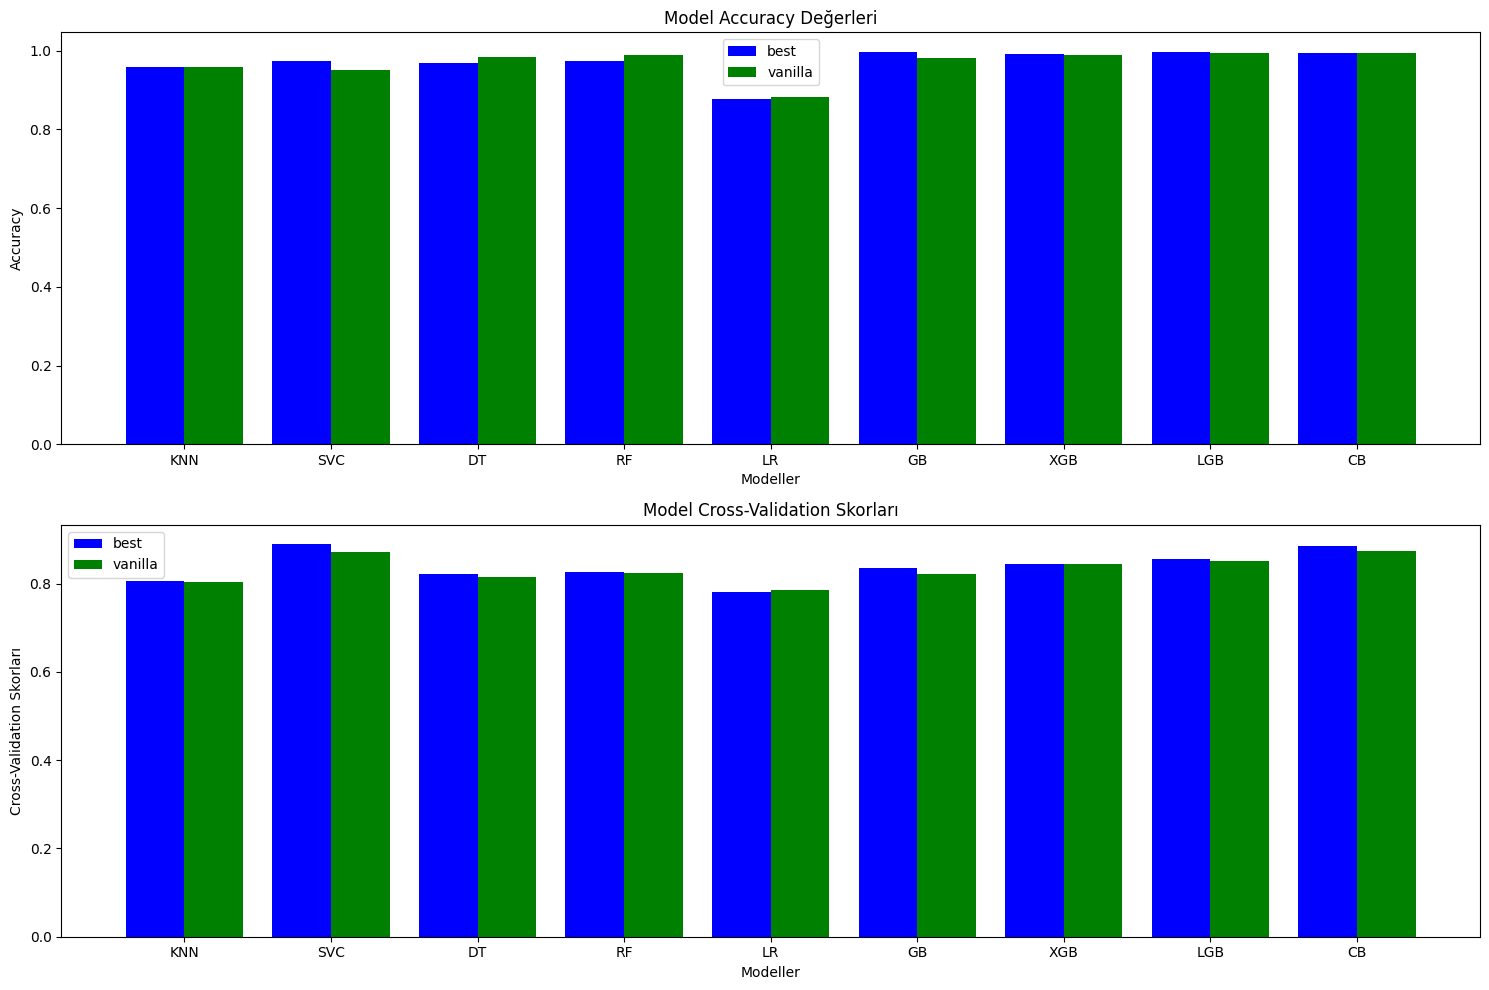

In [88]:
tuned_models = ["KNN","SVC","DT","RF","LR","GB","XGB","LGB","CB"]
best_accuracy_scores = [best_knn_scores[0], best_svc_scores[0], best_dt_scores[0], best_rf_scores[0], best_lr_scores[0], best_gb_scores[0], best_xgb_scores[0], best_lgb_scores[0], best_cb_scores[0]]
best_cv_scores =[best_knn_scores[3], best_svc_scores[3], best_dt_scores[3], best_rf_scores[3], best_lr_scores[3], best_gb_scores[3], best_xgb_scores[3], best_lgb_scores[3], best_cb_scores[3]]

models = ["KNN","SVC","DT","RF","LR","GB","XGB","LGB","CB"]
vanilla_accuracy_scores = [vanilla_knn_scores[0], vanilla_svc_scores[0], vanilla_dt_scores[0], vanilla_rf_scores[0],
                  vanilla_lr_scores[0], vanilla_gb_scores[0], vanilla_xgb_scores[0], vanilla_lgb_scores[0], vanilla_cb_scores[0]]
vanilla_cv_scores =[vanilla_knn_scores[3], vanilla_svc_scores[3], vanilla_dt_scores[3], vanilla_rf_scores[3], vanilla_lr_scores[3],
            vanilla_gb_scores[3],vanilla_xgb_scores[3], vanilla_lgb_scores[3], vanilla_cb_scores[3]]


plt.figure(figsize=(15, 10))
width = 0.4
plt.subplot(2, 1, 1)  # Birinci sütunda bir grafik
x = np.arange(len(models))
width = 0.4
plt.bar(x - width/2, best_accuracy_scores, width=width, color='blue', label = "best")
plt.bar(x + width/2, vanilla_accuracy_scores, width=width, color ="green", label = "vanilla")
plt.xlabel('Modeller')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Değerleri')
plt.xticks(x, models)
plt.legend()

plt.subplot(2, 1, 2)  # İkinci sütunda ikinci grafik
plt.bar(x - width/2, best_cv_scores, width=width, color='blue', label = "best")
plt.bar(x + width/2, vanilla_cv_scores, width=width, color ="green", label = "vanilla")

plt.xlabel('Modeller')
plt.ylabel('Cross-Validation Skorları')
plt.title('Model Cross-Validation Skorları')
plt.xticks(x, models)
plt.legend()

plt.tight_layout()  # Grafikleri düzenle

# Grafikleri göster
plt.show()


# Model Deployment

In [90]:
joblib.dump(best_cb, "CatBoostModel.joblib")

['CatBoostModel.joblib']